## Descriptives

In [82]:
# Open Spark session 
from pyspark.sql import SparkSession, functions as F


# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [83]:
# Read the files 
transactions_sample = spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot')
transactions_sample2 = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot')
transactions_sample3 = spark.read.parquet('../data/tables/transactions_20220228_20220828_snapshot')
transactions_sample.unionByName(transactions_sample2, True)
transactions_sample.unionByName(transactions_sample3, True)
consumer_details = spark.read.parquet('../data/tables/consumer_user_details.parquet')
merchants_tbl = spark.read.parquet('../data/tables/tbl_merchants.parquet')
customer_tbl = spark.read.option("delimiter", "|").option("header",True).csv('../data/tables/tbl_consumer.csv')

In [84]:
merchants = merchants_tbl.toPandas()

In [85]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
import string
import re

# This is used to for NLP of the description
def text_process(text):
    stemmer = WordNetLemmatizer()
    # Remove all punctuation and numbers 
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    # Remove all stopwords
    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    # lemmatize and output
    return ' '.join([stemmer.lemmatize(word) for word in nopunc])

In [86]:
# this function standardises the tags attribute, creating a list with the 'description', 'revenue band' and 'BNPL service charge'
nltk.download('stopwords')
nltk.download('wordnet')
def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)
    # break the string into sections
    string_cut = string.split('),')
    new_string = []
    # first extract the description and pre process
    descr = str(string_cut[0].strip('(('))
    #descr = re.sub(r'[-|,|_|:]', ' ', descr)
    #descr = re.sub(r' +', ' ', descr)
    #descr = descr.split()
    #descr = ' '.join([word for word in descr if word not in stop_words])
    new_string.append(text_process(descr))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))
    return(new_string)
################
# now we can run the algorithm
tags = merchants['tags']
processed_tags = []
for i in tags:
    processed_tags.append(tag_extract(i))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chaitanyaraghuvanshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chaitanyaraghuvanshi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [87]:
import pandas as pd
merchant_tbl = pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL_Fee'))
merchant_tbl = pd.concat([merchants, merchant_tbl], axis=1)
# drop the tags column 
merchant_tbl.drop(columns='tags', inplace=True)

In [88]:
set(merchant_tbl['Description'])

{'antique shop sale repair restoration service',
 'art dealer gallery',
 'artist supply craft shop',
 'bicycle shop sale service',
 'book periodical newspaper',
 'cable satellite pay television radio service',
 'computer computer peripheral equipment software',
 'computer programming data processing integrated system design service',
 'digital good book movie music',
 'equipment tool furniture appliance rent al leasing',
 'florist supply nursery stock flower',
 'furniture home furnishing equipment shop manufacturer except appliance',
 'gift card novelty souvenir shop',
 'health beauty spa',
 'hobby toy game shop',
 'jewelry watch clock silverware shop',
 'lawn garden supply outlet including nursery',
 'motor vehicle supply new part',
 'music shop musical instrument piano sheet music',
 'optician optical good eyeglass',
 'shoe shop',
 'stationery office supply printing writing paper',
 'telecom',
 'tent awning shop',
 'watch clock jewelry repair shop'}

In [89]:
merchant_tbl.head(5)

,name,merchant_abn,Description,Earnings_Class,BNPL_Fee
0,Felis Limited,10023283211,furniture home furnishing equipment shop manuf...,e,0.18
1,Arcu Ac Orci Corporation,10142254217,cable satellite pay television radio service,b,4.22
2,Nunc Sed Company,10165489824,jewelry watch clock silverware shop,b,4.40
3,Ultricies Dignissim Lacus Foundation,10187291046,watch clock jewelry repair shop,b,3.29
4,Enim Condimentum PC,10192359162,music shop musical instrument piano sheet music,a,6.33


In [90]:
merchants_tbl = spark.createDataFrame(merchant_tbl)
customer_tbl = customer_tbl.join(consumer_details, ['consumer_id'])

full_dataset = transactions_sample.join(customer_tbl, ['user_id'])
merchants_tbl = merchants_tbl.withColumnRenamed('name','company_name')
full_dataset = full_dataset.join(merchants_tbl, ['merchant_abn'])

In [91]:
full_dataset.limit(5)

merchant_abn,user_id,dollar_value,order_id,order_datetime,consumer_id,name,address,state,postcode,gender,company_name,Description,Earnings_Class,BNPL_Fee
71041015148,7,226.70111326425848,ba1c3c0b-6143-49c...,2021-11-26,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,Orci Ltd,digital good book...,c,2.19
14492521225,7,28.69248621050033,c82c2951-6a2c-4bf...,2021-11-26,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,Praesent Eu Assoc...,tent awning shop,c,2.5
68004106739,7,93.96901941736229,40d71489-2203-485...,2021-11-26,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,Nec Ante Ltd,cable satellite p...,a,5.61
34096466752,7,92.43454448910457,293dc228-8398-49f...,2021-11-29,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,Nullam Enim Ltd,computer computer...,b,3.22
62773208456,7,24.606053328805864,918d63ec-d125-43b...,2021-11-29,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,Ac Institute,watch clock jewel...,c,2.62


In [92]:
fraud_tbl = spark.read.option("header", True).csv("../data/tables/consumer_fraud_probability.csv")
fraud_tbl.limit(5)

user_id,order_datetime,fraud_probability
6228,2021-12-19,97.6298077657765
21419,2021-12-10,99.24738020302328
5606,2021-10-17,84.05825045251777
3101,2021-04-17,91.42192091901347
22239,2021-10-19,94.70342477508035


In [94]:
import matplotlib.pyplot as plt
import numpy as np

full_dataset.createOrReplaceTempView('data')
fraud_tbl.createOrReplaceTempView('fraud')
dataset = spark.sql("""
select Description, avg(fraud_probability) as description_avg from data, fraud where (fraud.user_id == data.user_id) AND (fraud.order_datetime == data.order_datetime)
group by Description""")
dataset = dataset.toPandas()

['lawn' 'bicycle' 'antique' 'book' 'artist' 'gift' 'shoe' 'health' 'art'
 'music' 'tent' 'motor' 'jewelry' 'stationery' 'telecom' 'optician'
 'digital' 'furniture' 'computer' 'computer' 'cable' 'equipment' 'watch'
 'hobby' 'florist']


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

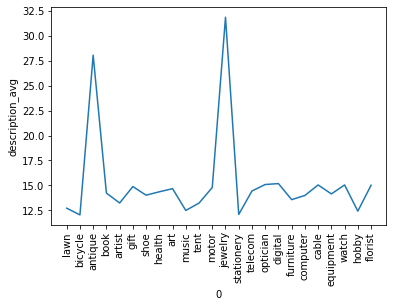

In [115]:
import seaborn as sns

tag_word=np.array([tag.split()[0] for tag in dataset.Description])
df1 = pd.DataFrame(tag_word, dataset.description_avg)

sns.lineplot(x=df1[0], y=df1.index)
plt.xticks(rotation=90)

As we can see from the graph above jewellery companies are having a comparatively higher fraud average probability followed by antique. Both of them are ones with high dollar value and fraud in such companies have been found in past literature (), therefore our analysis verifies the same.

In [ ]:
from pyspark.sql.functions import *
full_dataset = full_dataset.withColumn('day_of_week', dayofweek('order_datetime'))

In [ ]:
full_dataset.createOrReplaceTempView('data')
dataset.createOrReplaceTempView('fraud')
dataset = spark.sql("""
select * from data, fraud where fraud.Description == data.Description""")

In [ ]:
dataset.limit(5)

In [ ]:
Administrative_Support_Services= ["equipment tool furniture appliance rent al leasing", "florist supply nursery stock flower", "lawn garden supply outlet including nursery"]
Personal_Services= ["shoe shop", "gift card novelty souvenir shop", "antique shop sale repair restoration service", "watch clock jewellery repair shop", "jewellery watch clock silverware shop",  "motor vehicle supply new part", "furniture home furnishing equipment shop manufa...", "tent awning shop", "optician optical good eyeglass"]
Arts_Recreation_Services = ["digital good book movie music", "music shop musical instrument piano sheet music", "health beauty spa", "bicycle shop sale service", "art dealer gallery", "hobby toy game shop", "stationery office supply printing writing paper"]
Information_Media_Telecommunications = ["telecom", "computer programming data processing integrated...", "book periodical newspaper", "artist supply craft shop", "computer computer peripheral equipment software", "cable satellite pay television radio service"]
desc = []
tags = []
for ele in Administrative_Support_Services:
    desc.append("Administrative_Support_Services")
tags += Administrative_Support_Services
for ele in Personal_Services:
    desc.append("Personal_Services")
tags += Personal_Services
for ele in Arts_Recreation_Services:
    desc.append("Arts_Recreation_Services")
tags += Arts_Recreation_Services
for ele in Information_Media_Telecommunications:
    desc.append("Information_Media_Telecommunications")
tags += Information_Media_Telecommunications

to_df = {
    "sector" :  desc,
    "Description" : tags
}
sectors = spark.createDataFrame(pd.DataFrame(to_df))
dataset_sect = dataset.join(sectors, ['Description'])
dataset_sect.createOrReplaceTempView('data')
dataset_sect_final = dataset_sect.join(spark.sql("""select sector, avg(description_avg) as sector_avg from data group by sector"""), ['sector'])
dataset_sect_final.limit(5)

In [ ]:
sect_avg = spark.sql("""select sector, avg(description_avg) as sector_avg from data group by sector""")

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

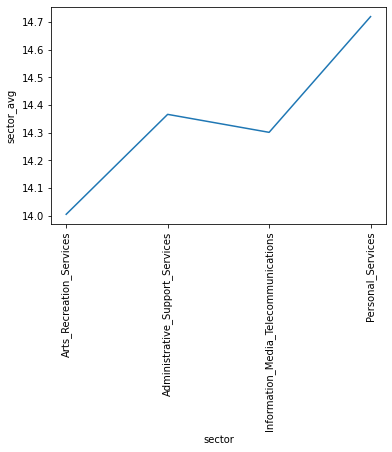

In [119]:
sect_avg = sect_avg.toPandas()
import seaborn as sns
sns.lineplot(x=sect_avg.sector, y=sect_avg.sector_avg)
plt.xticks(rotation=90)

Our analysis is futher supported by the graph above which shows personal services like antiques, watch and jewellery have higher chances of being fraud.

In [120]:
dataset_sect_final.limit(5)

sector,Description,merchant_abn,user_id,dollar_value,order_id,order_datetime,consumer_id,name,address,state,postcode,gender,company_name,Earnings_Class,BNPL_Fee,day_of_week,Description,description_avg,sector_avg
Arts_Recreation_S...,bicycle shop sale...,54272781746,7,344.1742940044132,f69babdc-cc77-44c...,2021-11-13,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,Non Massa Institute,b,4.54,7,bicycle shop sale...,12.047653726512607,14.004410176695506
Arts_Recreation_S...,bicycle shop sale...,79633007926,7,87.94122487213117,d51c24e1-850e-467...,2021-11-10,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,Auctor Vitae Inc.,b,4.19,4,bicycle shop sale...,12.047653726512607,14.004410176695506
Arts_Recreation_S...,bicycle shop sale...,84088835754,7,36.76843285730786,61351136-725d-49c...,2021-09-04,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,Congue Turpis In LLC,a,5.77,7,bicycle shop sale...,12.047653726512607,14.004410176695506
Arts_Recreation_S...,bicycle shop sale...,62204398944,19,111.7359063753297,163beb6a-1d72-453...,2021-11-23,1226530,Victoria Gonzalez,68657 Johnson Gle...,TAS,7276,Female,Vel Institute,a,6.79,3,bicycle shop sale...,12.047653726512607,14.004410176695506
Arts_Recreation_S...,bicycle shop sale...,52594457116,19,167.98905905096947,26520d60-8fd7-4f1...,2021-12-08,1226530,Victoria Gonzalez,68657 Johnson Gle...,TAS,7276,Female,Vel Turpis Aliqua...,a,5.51,4,bicycle shop sale...,12.047653726512607,14.004410176695506


In [127]:
dataset_sect_final.groupBy("sector").sum("dollar_value")

+--------------------+--------------------+
|              sector|   sum(dollar_value)|
+--------------------+--------------------+
|Arts_Recreation_S...| 1.583765465871919E8|
|Administrative_Su...| 8.229103223916568E7|
|Information_Media...|1.5082491745003042E8|
|   Personal_Services|1.8858939346796408E8|
+--------------------+--------------------+

